In [1]:
import geopandas as gpd
from geopandas.tools import overlay
import os
import matplotlib.pyplot as plt
import boto3
import zipfile
import sys
import xarray as xr
import pandas as pd
from datetime import datetime
from functools import wraps
import re

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.write_metadata import (
    append_metadata
)

In [2]:
s3_client = boto3.client('s3')
def list_geospatial_files(path):
    """ Build a list of shapefile URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_shapefiles = []
    bucket_name = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    # iterate through directory
    for obj in my_bucket.objects.filter(
        Prefix=path):
        # build list of shapefile URIs
        if obj.key.endswith('.zip'):
            # preceding the URI with 'zip' lets you read in the file without downloading, unzipping, etc
            s3_uri = f"zip+s3://ca-climate-index/"+obj.key
            all_shapefiles.append(s3_uri)
        elif obj.key.endswith('.shp'):
            s3_uri = "s3://ca-climate-index/"+obj.key
            all_shapefiles.append(s3_uri)
    return all_shapefiles

# @append_metadata
def reproject_shapefile(shp_fname, ca_boundaries, varname='', additional_comments='N/A'):
    """ Given S3 URI which corresponds to a data shapefile and a shapefile
    with California Census Tract, (1) reproject the data shapefile to the CRS of the California Census Tracts, 
    (2) clip to California, and (3) send it off to S3. """    

    # read in shapefile of interest from S3 and take a look at it
    gdf = gpd.read_file(shp_fname)
    print(f"Reading in shapefile: {shp_fname}")
    print(f"Original CRS of {varname}: {gdf.crs}")
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, markersize=1)
    plt.title(f"{varname} on original projection")
    plt.show()

    # check the current coordinate system of the census tracts data
    print(f"CRS of Census Tracts Shapefile: {ca_boundaries.crs}")

    # reproject the data to the census tract CRS and clip to California
    gdf_reprojected = gdf.to_crs(ca_boundaries.crs)
    print(f"{varname} reprojected from {gdf.crs} to {gdf_reprojected.crs} with geopandas to_crs() function.")

    clipped_gdf = overlay(gdf_reprojected, ca_boundaries, how='intersection')
    print(f"{varname} clipped to California boundaries via geopandas overlay using the 'intersection' method.")
    print(f"Additional comments: {additional_comments}.") # eg, code rerun, bug fix, etc

    # visualize results
    fig, ax = plt.subplots()
    ca_boundaries.plot(ax=ax, color='white', edgecolor='black')
    clipped_gdf.plot(ax=ax, marker='o', color='red', markersize=1)
    plt.title(f"{varname} on new projection")
    plt.show()
  
    # write the reprojected file to disk - still looking for a way around this
    # if not os.path.exists(f"{varname}.gpkg"):
    clipped_gdf.to_file(f"{varname}.gpkg", driver="GPKG")
    print(f"{varname}.gpkg has been made")
    print(f'Uploading file {varname}.gpkg to AWS')
    
    # upload it to S3
    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index' 

    if shp_fname.endswith('.zip'):
        shp_fname = shp_fname.replace(
            'zip+',
            '')
    dest_path = shp_fname.replace(
        's3://ca-climate-index/',
        '')
    dest_path = re.sub(r'1_pull_data|2a_subset', '2b_reproject', dest_path)
    dest_path = dest_path.replace(dest_path.split('/')[-1],f"{varname}.gpkg")

    s3_client.upload_file(f"{varname}.gpkg", f'{bucket_name}', f'{dest_path}'
    )
    print(f"Reprojected data called {varname}.gpkg sent to S3 bucket: {dest_path}")
    print('')
    os.remove(f"{varname}.gpkg")


In [3]:
# read in the CSV with the data details
ref_file = sys.path[-1]+'/metadata/Full Data Pipeline Notes - 1_ Pull.csv'
df = pd.read_csv(ref_file)

# subset for shapefiles
ref_df = df.fillna('N/A')
ref_df = ref_df[ref_df["Pulled Format"].str.contains("shp")]

### Define the path
path1 = "1_pull_data"
path2 = "2a_subset"
#  build a list of shapefiles in the above s3 paths
my_list = list_geospatial_files(path1) 
my_list += list_geospatial_files(path2)

# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
# need to rename columns so we don't have any duplicates in the final geodatabase
column_names = ca_boundaries.columns
new_column_names = ["USCB_"+column for column in column_names if column != "geometry"]
ca_boundaries = ca_boundaries.rename(columns=dict(zip(column_names, new_column_names)))

Skipping file CPUC_WEB_Dec2021.gdb.zip as it is not in the list of files to process.
Skipping file Cellular_Towers.zip as it is not in the list of files to process.
Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/FM_Transmission_Towers.zip
Original CRS of built_hifld_radio_towers: EPSG:3857


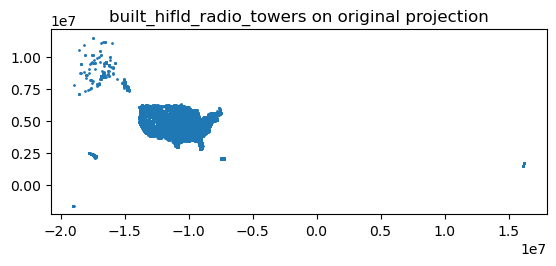

CRS of Census Tracts Shapefile: EPSG:4269
built_hifld_radio_towers reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_hifld_radio_towers clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


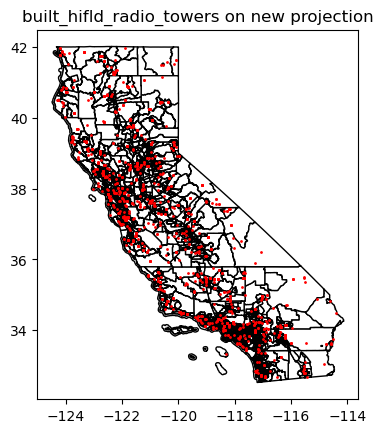

built_hifld_radio_towers.gpkg has been made
Uploading file built_hifld_radio_towers.gpkg to AWS
Reprojected data called built_hifld_radio_towers.gpkg sent to S3 bucket: 2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/built_hifld_radio_towers.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/Land_Mobile_Broadcast_Towers.zip
Original CRS of built_hifld_mobile_towers: EPSG:4326


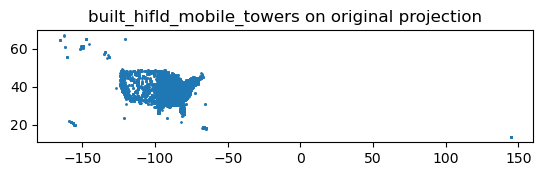

CRS of Census Tracts Shapefile: EPSG:4269
built_hifld_mobile_towers reprojected from EPSG:4326 to EPSG:4269 with geopandas to_crs() function.
built_hifld_mobile_towers clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


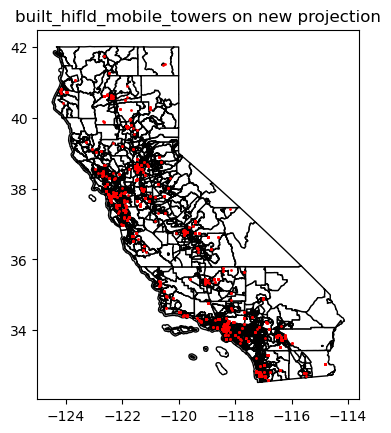

built_hifld_mobile_towers.gpkg has been made
Uploading file built_hifld_mobile_towers.gpkg to AWS
Reprojected data called built_hifld_mobile_towers.gpkg sent to S3 bucket: 2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/built_hifld_mobile_towers.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/Microwave_Service_Towers.zip
Original CRS of built_hifld_microwave_towers: EPSG:4326


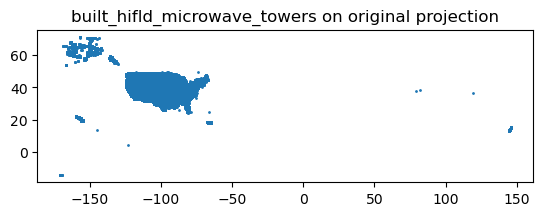

CRS of Census Tracts Shapefile: EPSG:4269
built_hifld_microwave_towers reprojected from EPSG:4326 to EPSG:4269 with geopandas to_crs() function.
built_hifld_microwave_towers clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


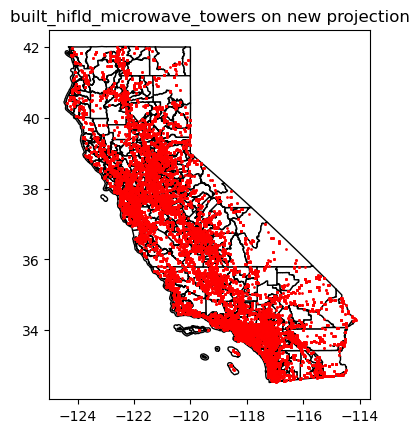

built_hifld_microwave_towers.gpkg has been made
Uploading file built_hifld_microwave_towers.gpkg to AWS
Reprojected data called built_hifld_microwave_towers.gpkg sent to S3 bucket: 2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/built_hifld_microwave_towers.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/Paging_Transmission_Towers.zip
Original CRS of built_hifld_paging_towers: EPSG:3857


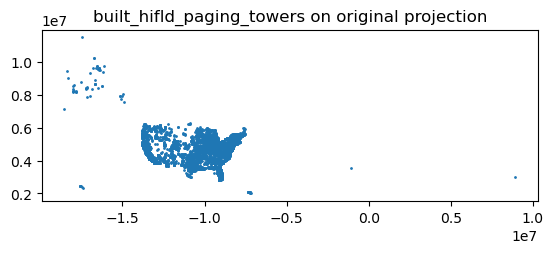

CRS of Census Tracts Shapefile: EPSG:4269
built_hifld_paging_towers reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_hifld_paging_towers clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


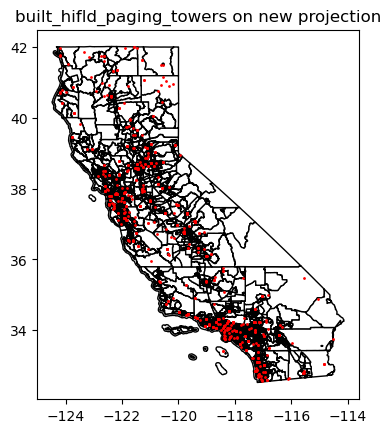

built_hifld_paging_towers.gpkg has been made
Uploading file built_hifld_paging_towers.gpkg to AWS
Reprojected data called built_hifld_paging_towers.gpkg sent to S3 bucket: 2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data/built_hifld_paging_towers.gpkg

Skipping file TV_Broadcast_Contours.zip as it is not in the list of files to process.
Skipping file acs_2022_housing_age_quality_structure.zip as it is not in the list of files to process.
Skipping file acs_2022_housing_vacancy.zip as it is not in the list of files to process.
Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/Bottlenecks.zip
Original CRS of built_caltrans_road_bottlenecks: EPSG:3857


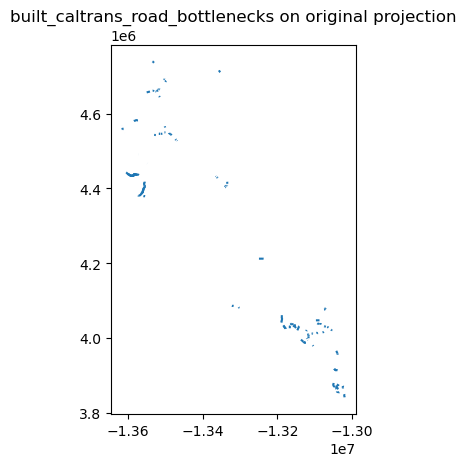

CRS of Census Tracts Shapefile: EPSG:4269
built_caltrans_road_bottlenecks reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_caltrans_road_bottlenecks clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


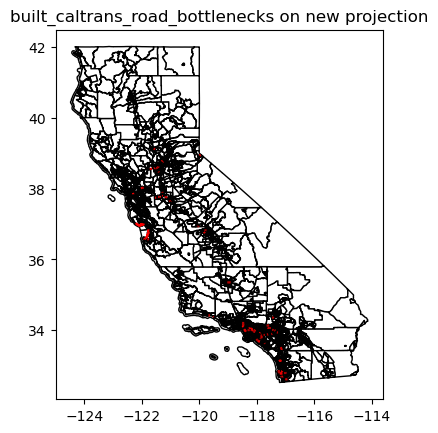

built_caltrans_road_bottlenecks.gpkg has been made
Uploading file built_caltrans_road_bottlenecks.gpkg to AWS
Reprojected data called built_caltrans_road_bottlenecks.gpkg sent to S3 bucket: 2b_reproject/built_environment/transportation/cdot/built_caltrans_road_bottlenecks.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/California_Rail_Network.zip
Original CRS of built_caltrans_rails: EPSG:3857


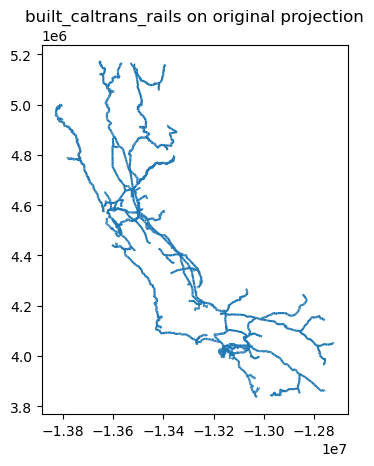

CRS of Census Tracts Shapefile: EPSG:4269
built_caltrans_rails reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_caltrans_rails clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


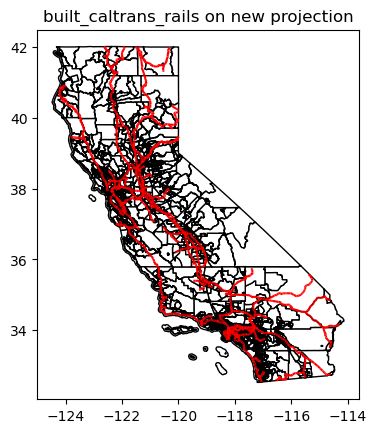

built_caltrans_rails.gpkg has been made
Uploading file built_caltrans_rails.gpkg to AWS
Reprojected data called built_caltrans_rails.gpkg sent to S3 bucket: 2b_reproject/built_environment/transportation/cdot/built_caltrans_rails.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/Local_Bridges.zip
Original CRS of built_caltrans_bridges: EPSG:3857


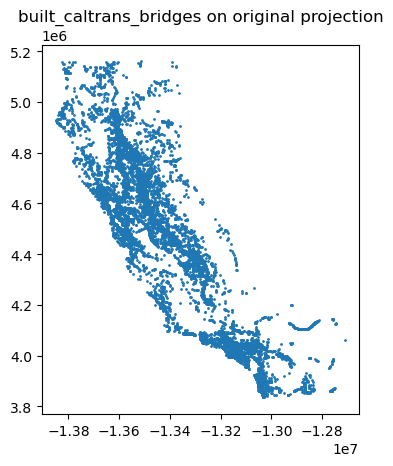

CRS of Census Tracts Shapefile: EPSG:4269
built_caltrans_bridges reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_caltrans_bridges clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


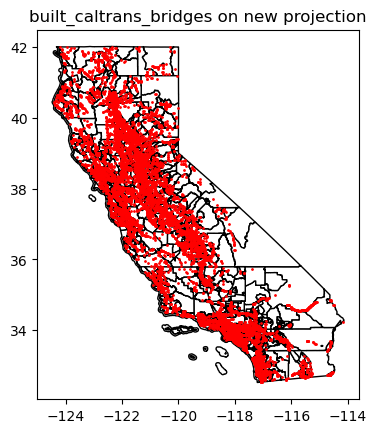

built_caltrans_bridges.gpkg has been made
Uploading file built_caltrans_bridges.gpkg to AWS
Reprojected data called built_caltrans_bridges.gpkg sent to S3 bucket: 2b_reproject/built_environment/transportation/cdot/built_caltrans_bridges.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/National_Highway_System.zip
Original CRS of built_caltrans_highways: EPSG:3857


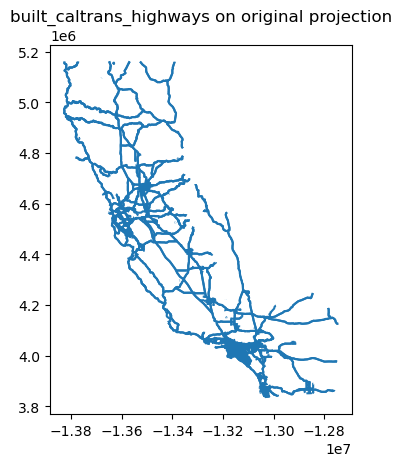

CRS of Census Tracts Shapefile: EPSG:4269
built_caltrans_highways reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_caltrans_highways clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


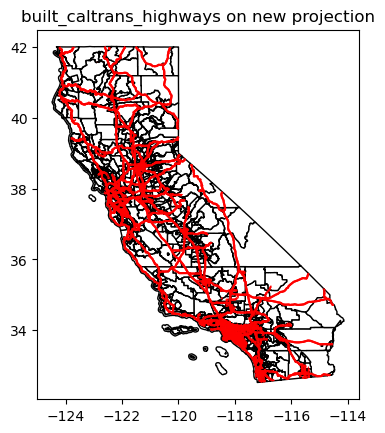

built_caltrans_highways.gpkg has been made
Uploading file built_caltrans_highways.gpkg to AWS
Reprojected data called built_caltrans_highways.gpkg sent to S3 bucket: 2b_reproject/built_environment/transportation/cdot/built_caltrans_highways.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/Public_Airport.zip
Original CRS of built_caltrans_airports: EPSG:3857


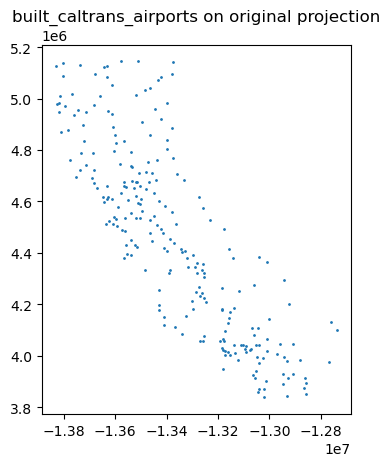

CRS of Census Tracts Shapefile: EPSG:4269
built_caltrans_airports reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_caltrans_airports clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


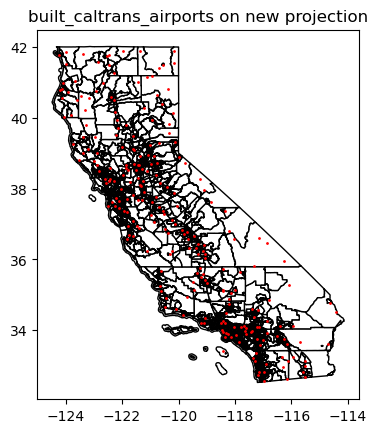

built_caltrans_airports.gpkg has been made
Uploading file built_caltrans_airports.gpkg to AWS
Reprojected data called built_caltrans_airports.gpkg sent to S3 bucket: 2b_reproject/built_environment/transportation/cdot/built_caltrans_airports.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/utilities/ca_energy_commission/California_Electric_Transmission_Lines.zip
Original CRS of built_cec_transmission_lines: EPSG:3857


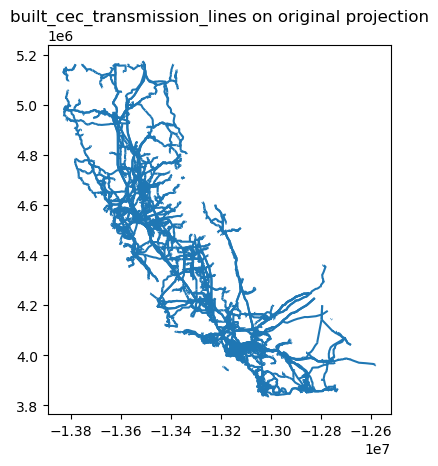

CRS of Census Tracts Shapefile: EPSG:4269
built_cec_transmission_lines reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
built_cec_transmission_lines clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


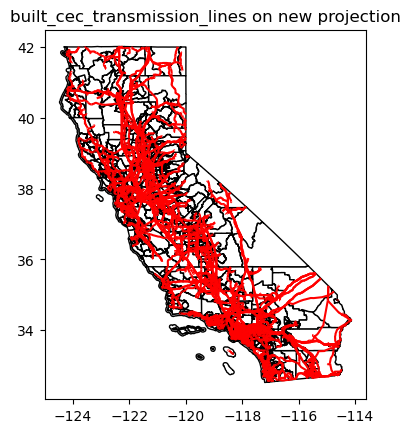

built_cec_transmission_lines.gpkg has been made
Uploading file built_cec_transmission_lines.gpkg to AWS
Reprojected data called built_cec_transmission_lines.gpkg sent to S3 bucket: 2b_reproject/built_environment/utilities/ca_energy_commission/built_cec_transmission_lines.gpkg

Reading in shapefile: zip+s3://ca-climate-index/1_pull_data/built_environment/utilities/ca_energy_commission/California_Power_Plants.zip
Original CRS of built_cec_power_plants: EPSG:4269


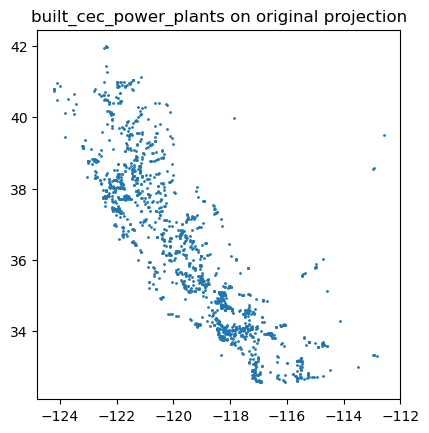

CRS of Census Tracts Shapefile: EPSG:4269
built_cec_power_plants reprojected from EPSG:4269 to EPSG:4269 with geopandas to_crs() function.
built_cec_power_plants clipped to California boundaries via geopandas overlay using the 'intersection' method.
Additional comments: N/A.


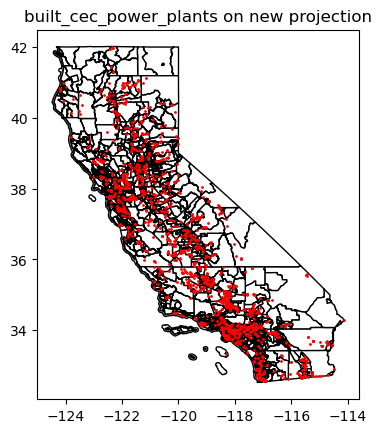

built_cec_power_plants.gpkg has been made
Uploading file built_cec_power_plants.gpkg to AWS
Reprojected data called built_cec_power_plants.gpkg sent to S3 bucket: 2b_reproject/built_environment/utilities/ca_energy_commission/built_cec_power_plants.gpkg

Skipping file col_indem_1989.zip as it is not in the list of files to process.
Skipping file col_indem_1990.zip as it is not in the list of files to process.
Skipping file col_indem_1991.zip as it is not in the list of files to process.
Skipping file col_indem_1992.zip as it is not in the list of files to process.
Skipping file col_indem_1993.zip as it is not in the list of files to process.
Skipping file col_indem_1994.zip as it is not in the list of files to process.
Skipping file col_indem_1995.zip as it is not in the list of files to process.
Skipping file col_indem_1996.zip as it is not in the list of files to process.
Skipping file col_indem_1997.zip as it is not in the list of files to process.
Skipping file col_indem_1998.zip as

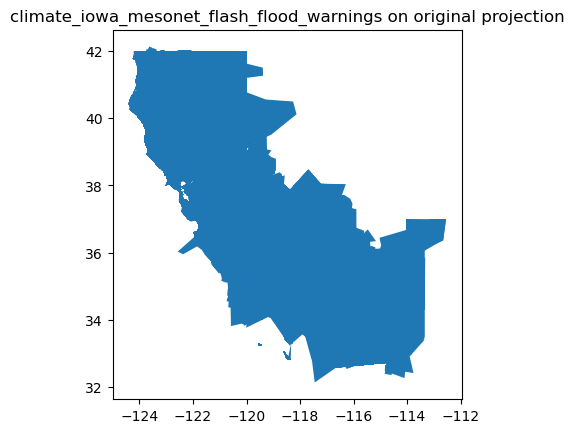

CRS of Census Tracts Shapefile: EPSG:4269
climate_iowa_mesonet_flash_flood_warnings reprojected from EPSG:4326 to EPSG:4269 with geopandas to_crs() function.


In [ ]:
# sample for testing
file_names = [ 
    'Bottlenecks.zip',
    'FM_Transmission_Towers.zip',
    'sta_tv_contours.zip',
    "TV_Broadcast_Contours.zip"
    'Cellular_Towers.zip',
    'Microwave_Service_Towers.zip',
    'Paging_Transmission_Towers.zip',
    'Land_Mobile_Broadcast_Towers.zip',
    'sta_tv_contours.zip',
    'California_Rail_Network.zip',
    'Local_Bridges.zip',
    'National_Highway_System.zip',
    'Public_Airport.zip',
    'California_Electric_Transmission_Lines.zip',
    'California_Power_Plants.zip',
    'california-fema-100-year-floodplains.gdb.zip',
    # 'flash_flood_warnings_1986_2024.zip', # too large
]

# test additional comments for fun
additional_comments = "N/A"

# full list of file names here - still need to do some tweaking
# file_names = [name for name in ref_df['File Name'].values if name != 'N/A']

# iterate through the list 
for fpath in my_list:
    # get the file name by itself (no subdirectories)
    fname = fpath.split('/')[-1]
    if fname in file_names:
         # want the subsetted TV contours data in 2a_subset folder
        if fname=="TV_Broadcast_Contours.zip":
            continue
        if fname =='sta_tv_contours.zip':
            varname = "built_hifld_tv_contour"
        else:
            # match up file name to variable name
            varname = ref_df.loc[ref_df["File Name"] == fname]["Variable"].values[0]
        reproject_shapefile(fpath, ca_boundaries, varname=varname, additional_comments=additional_comments)
    else:
        print(f"Skipping file {fname} as it is not in the list of files to process.")


# Troubleshooting code below

In [5]:
def troubleshoot_reproject(shp_fname, ca_boundaries, varname='', additional_comments='N/A'):
    """ Given S3 URI which corresponds to a shapefile, (1) reproject it
    to the CRS of the California Census Tracts, (2) clip to California, 
    and (3) send it off to S3. """    

    # check the current coordinate system of the census tracts data
    print(f"CRS of Census Tracts Shapefile: {ca_boundaries.crs}")
    # reproject the data to the census tract CRS and clip to California
    gdf_reprojected = gdf.to_crs(ca_boundaries.crs)
    print(f"{varname} reprojected from {gdf.crs} to {gdf_reprojected.crs} with geopandas to_crs() function.")
    clipped_gdf = overlay(gdf_reprojected, ca_boundaries, how='intersection')
    return gdf_reprojected, clipped_gdf

fpath = "zip+s3://ca-climate-index/1_pull_data/built_environment/transportation/cdot/Bottlenecks.zip"
gdf = gpd.read_file(fpath)
reproj, clipped_gdf = troubleshoot_reproject(fpath, ca_boundaries, varname='bottlenecks_test')

CRS of Census Tracts Shapefile: EPSG:4269
bottlenecks_test reprojected from EPSG:3857 to EPSG:4269 with geopandas to_crs() function.
